In [1]:
import os
import sys
sys.path.insert(0,os.path.join('/project/venv/vit_xai/lib/python3.8/site-packages/'))

In [2]:
os.environ

environ{'SHELL': '/bin/bash',
        'JUPYTERHUB_API_TOKEN': 'c00f6becb6874570bf66f24bc8ce8a47',
        'PY_VERSION': '3.8',
        'JUPYTERHUB_BASE_URL': '/jupyter/n06-00/',
        'NCCL_VERSION': '2.16',
        'PWD': '/home/starzew',
        'TRT_VERSION': '8.5',
        'JUPYTERHUB_SERVER_NAME': '',
        'HOME': '/home/starzew',
        'CUDNN_PATH': '/usr/local/cuda-11.8/cudnn-8.7',
        'LANG': 'en_US.UTF-8',
        'JPY_API_TOKEN': 'c00f6becb6874570bf66f24bc8ce8a47',
        'JUPYTERHUB_SERVICE_PREFIX': '/jupyter/n06-00/user/starzew/',
        'TRT_PATH': '/usr/local/cuda-11.8/tensorRT-8.5',
        'JUPYTERHUB_OAUTH_CALLBACK_URL': '/jupyter/n06-00/user/starzew/oauth_callback',
        'PYTHONPATH': '/scratch/starzew/python/lib/python3.8/site-packages:/usr/local/cuda-11.8/tensorRT-8.5/lib/python3.8/dist-packages:/usr/local/jupyter/lib/python3.8/site-packages',
        'CPLUS_INCLUDE_PATH': '/scratch/starzew/python/include:/usr/local/cuda-11.8/include:/usr/local/cuda-

In [3]:
sys.path

['/project/venv/vit_xai/lib/python3.8/site-packages/',
 '/project/experiments',
 '',
 '/scratch/starzew/python/lib/python3.8/site-packages',
 '/usr/local/cuda-11.8/tensorRT-8.5/lib/python3.8/dist-packages',
 '/usr/local/jupyter/lib/python3.8/site-packages',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/jupyter/lib/python3.8/site-packages/IPython/extensions',
 '/home/starzew/.ipython']

In [4]:
!nvidia-smi

Tue Aug 20 07:52:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:3D:00.0 Off |                  N/A |
|  0%   21C    P8               1W / 250W |   9983MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['HTTP_PROXY'] = 'http://fp.cs.ovgu.de:3210/'
os.environ['HTTPS_PROXY'] = 'http://fp.cs.ovgu.de:3210/'

In [6]:
#import torch

#if torch.cuda.is_available():
#    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
#else:
#    print("GPU is not available")


# Import libraries

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from transformers import TFViTForImageClassification, ViTImageProcessor
import tensorflow as tf
from datasets import load_dataset
from skimage.util import view_as_blocks
from numpy.linalg import norm
from itertools import combinations
import shutil

2024-08-20 07:52:09.932187: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 07:52:09.978289: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load data

In [8]:
val_data = load_dataset("frgfm/imagenette", "full_size", trust_remote_code=True,split='validation')

In [9]:
val_data.shuffle()

Dataset({
    features: ['image', 'label'],
    num_rows: 3925
})

# Get concepts

In [10]:
concepts = [[],[],[],[],[],[],[],[],[],[]]
labels = []
n_examples = 20

for item in val_data:
    if np.array(item['image']).shape[-1]==3: # only look at images with 3 channels
        if (item['label']==0) & (len(concepts[0])<n_examples): #"tench"       # get the correct label
            labels.append(0)
            concepts[0].append([np.array(item['image']),item['label']])
        elif (item['label']==1) & (len(concepts[1])<n_examples): #"English springer"
            labels.append(217)
            concepts[1].append([np.array(item['image']),item['label']])
        elif (item['label']==2) & (len(concepts[2])<n_examples): #"cassette player"
            labels.append(482)
            concepts[2].append([np.array(item['image']),item['label']])
        elif (item['label']==3) & (len(concepts[3])<n_examples): #"chain saw"
            labels.append(491)
            concepts[3].append([np.array(item['image']),item['label']])
        elif (item['label']==4) & (len(concepts[4])<n_examples): #"church"
            labels.append(497)
            concepts[4].append([np.array(item['image']),item['label']])
        elif (item['label']==5) & (len(concepts[5])<n_examples): #"French horn"
            labels.append(566)
            concepts[5].append([np.array(item['image']),item['label']])
        elif (item['label']==6) & (len(concepts[6])<n_examples): #"garbage truck"
            labels.append(569)
            concepts[6].append([np.array(item['image']),item['label']])
        elif (item['label']==7) & (len(concepts[7])<n_examples): # "gas pump"
            labels.append(571)
            concepts[7].append([np.array(item['image']),item['label']])
        elif (item['label']==8) & (len(concepts[8])<n_examples): # "golf ball"
            labels.append(574)
            concepts[8].append([np.array(item['image']),item['label']])
        elif (item['label']==9) & (len(concepts[9])<n_examples): #"parachute"
            labels.append(701)
            concepts[9].append([np.array(item['image']),item['label']])

In [11]:
def print_examples(concept):
  for i in range(0,10):
    plt.subplot(1,10,i+1)
    plt.imshow(concept[i][0])
    plt.axis("off")

  plt.tight_layout()
  plt.show()

In [ ]:
plt.imshow(concept[])

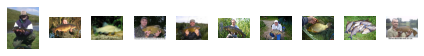

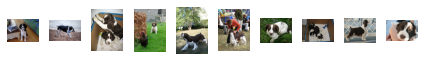

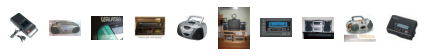

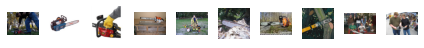

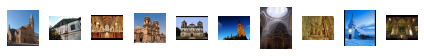

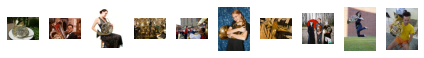

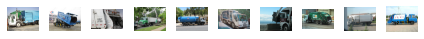

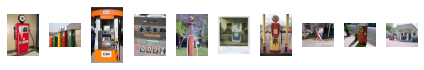

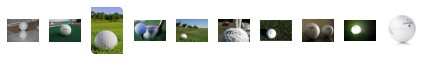

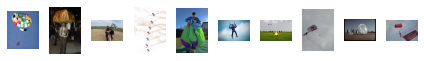

In [12]:
# for each class take the first n_examples images to form concept
for concept in concepts:
    print_examples(concept)

# Load pretrained model

In [13]:
model = TFViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

image_processor = ViTImageProcessor()

2024-08-20 07:52:33.121020: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9803 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3e:00.0, compute capability: 7.5
All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


In [14]:
model.summary(expand_nested=True)

Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  769000    
                                                                 
Total params: 86567656 (330.23 MB)
Trainable params: 86567656 (330.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
print(model.config)

ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduelis carduelis",
    "12": "house finch, linnet, Carpodacus mexicanus",
    "13": "junco, snowbird",
    "14": "indigo bunting, indigo finch, indigo bird, Passerina cyanea",
    "15": "robin, American robin, Turdus migratorius",
    "16": "bulbul",
 

# Concept embeddings

In [16]:
#  average the embedding for a concept -> concept embedding
def average_embedding(embedding):
    embedding = embedding.numpy() # (20, 197, 768)
    embedding = embedding[:,1:,:] # drop CLS -> (20, 196, 768)
    embedding = embedding.mean(axis=0) # mean over batch
    embedding = embedding.mean(axis=0) # mean over patches
    # embedding (768,)
    
    return embedding

# embedding of one example image of a concept
def image_embedding(embedding):
    embedding = embedding.numpy() # (197, 768)
    embedding = embedding[1:,:] # drop CLS -> (196, 768)
    embedding = embedding.mean(axis=0) # mean over patches
    # embedding (768,)
    
    return embedding


# average the embedding for a concept -> concept embedding, only using k most relevant patches
def average_embedding_top_k(embedding, k, relevances, modus):
    # embedding (20, 197, 768) 
    # relevances  (20,196)
    
    avg = []
    for i, relevance in enumerate(relevances): # relevance: (196,) -> relevances are for all examples of a concept; i--> ith image of a concept
        # take only k most important patches
        if modus == "top": # normal top-k selection
            _, indices = tf.math.top_k(relevance, k=k, sorted=True)
        elif modus == "bottom": # flipped top-k selection
            _, indices = tf.math.top_k(-1*relevance, k=k, sorted=True)
        elif modus == "random": # random selection
            indices = tf.random.uniform(shape=(30,), minval=0,maxval=195, dtype=tf.int64)
        else:
            raise "Modus not supported"
        
        indices = indices.numpy() # (30,)
        intermediate = embedding[i,1:,:].numpy() # (197, 768) # take embedding of ith example corresponding to relevance, remove CLS
        intermediate = tf.gather(intermediate, indices).numpy() # take only top-k patches -> (30, 768)
        intermediate = np.array(intermediate.mean(axis=0)) # mean over patches -> (768,)
        avg.append(intermediate)  # avg embedding of image
    avg = np.array(avg).mean(axis=0) # mean over examples (20, 768) -> (768,) avg embedding of whole concept

    return avg

# embedding of one example image of a concept only using top k most relevant patches
def image_embedding_top_k(embedding, k, relevances, modus):
    # embedding (197, 768) 
    # relevances  (196)
    
    # take only k most important patches
    if modus == "top": # normal top-k selection
        _, indices = tf.math.top_k(relevances, k=k, sorted=True)
    elif modus == "bottom": # flipped top-k selection
        _, indices = tf.math.top_k(-1*relevances, k=k, sorted=True)
    elif modus == "random": # random selection
        indices = tf.random.uniform(shape=(30,), minval=0,maxval=195, dtype=tf.int64)
    else:
        raise "Modus not supported"
        
    indices = indices.numpy() # (30,)
    intermediate = embedding[1:,:].numpy() # (197, 768) #  remove CLS
    intermediate = tf.gather(intermediate, indices).numpy() # take only top-k patches -> (30, 768)
    intermediate = np.array(intermediate.mean(axis=0)) # mean over patches -> (768,)
    
    return intermediate

In [17]:
def get_embeddings_and_attentions(concepts_selected):
    # Get Input for the model wrt different concepts
    inputs = []
    for concept in concepts_selected:
        x_concept,_ = zip(*concept)
        inputs.append(image_processor(x_concept, return_tensors="tf").pixel_values)

    # make predictions
    preds = []
    for input in inputs:
        pred = model(input, output_hidden_states=True, output_attentions=True)
        preds.append(pred)


    # for each concept in concept_nums(4): for each layer (13): (20,197,768)
    embeddings_list = []
    # for each concept in concept_nums(4): for each layer (12): (20,12,197,197)
    attentions_list = []
    for pred in preds:
        embeddings_list.append(pred.hidden_states)
        attentions_list.append(pred.attentions)
        
    return embeddings_list, attentions_list


def get_embeddings(concepts):
    # Get Input for the model wrt different concepts
    inputs = []
    for concept in concepts:
        x_concept,_ = zip(*concept)
        inputs.append(image_processor(x_concept, return_tensors="tf").pixel_values)

    # make predictions
    preds = []
    for input in inputs:
        pred = model(input, output_hidden_states=True, output_attentions=True)
        preds.append(pred)


    # for each concept in concept_nums(4): for each layer (13): (20,197,768)
    embeddings_list = []

    for pred in preds:
        embeddings_list.append(pred.hidden_states)
        
    return embeddings_list

## Finding a scale for the distances

In [18]:
# for every concept (10), for every layer (13): (20,197,768)
embeddings_list_scales = get_embeddings(concepts)
scales = tf.norm(embeddings_list_scales, axis=-1) # (10,13,20,197)
scales = np.mean(scales, axis=-1) # (10,13,20)
scales = np.mean(scales, axis=-1) # (10,13)


2024-08-20 07:52:36.798363: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8700


In [19]:
scales = np.mean(scales, axis=0) #(13,)
scales = scales[:12] # drop last layer (12,)
scales

array([ 18.701006,  28.894688,  33.02833 ,  38.94409 ,  44.179382,
        58.105507, 106.80548 , 148.59277 , 160.70662 , 172.58366 ,
       193.49648 , 248.27312 ], dtype=float32)

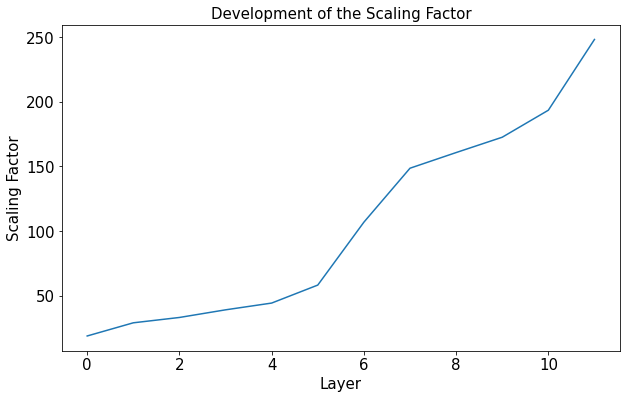

In [20]:
plt.figure(figsize=(10,6))
plt.plot(range(12), scales)
plt.xlabel("Layer", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Scaling Factor", fontsize=15)
plt.yticks(fontsize=15)
plt.title("Development of the Scaling Factor", fontsize=15)
plt.show()

## Patch selection

In [21]:
k = 50
concept_nums = np.array([0,1,2,3,4,5,6,7,8,9])
concepts_selected = [concepts[i] for i in concept_nums]
layer_num = 0

embeddings_list, attentions_list = get_embeddings_and_attentions(concepts_selected)


# for each concept in concept_nums (4): for each layer (13): avg embedding = 197 values
#avg_embeddings_list = []
#for embeddings in embeddings_list:
#  avg_embeddings_list.append(average_embedding(embeddings[layer_num]))

### Attention Rollout

In [22]:
#https://github.com/jacobgil/vit-explain/blob/main/vit_rollout.py

def rollout(attentions, discard_ratio, head_fusion, layer_num):
  # attentions: for 12 layers: (20, 12, 197, 197) = (batch_size, n_heads, sequence_len, sequence_len)
  result = tf.eye(attentions[0].shape[-1]) # result.shape=(197,197), attentions[0].shape (1, 12, 197, 197)
  for i, attention in enumerate(attentions[::-1]):
    if i + layer_num == 13: # do rollout only until specified layer ------------------- 
        break
    if head_fusion == "mean":
      attention_heads_fused = attention.numpy().mean(axis=1)
    elif head_fusion == "max":
      attention_heads_fused = attention.numpy().max(axis=1)[0]
    elif head_fusion == "min":
      attention_heads_fused = attention.numpy().min(axis=1)#[0]
    else:
      raise "Attention head fusion type Not supported"

    # attention_heads_fused.shape -> (1,197,197)

    # Drop the lowest attentions, but
    # don't drop the class token
    flat = attention_heads_fused.reshape(attention_heads_fused.shape[0], -1) # flat.shape -> (1, 38809)
    _, indices = tf.math.top_k(flat, k=int(flat.shape[-1]*discard_ratio), sorted=False)
    indices = indices[indices != 0]
    flat[0, indices] = 0

    I = tf.eye(attention_heads_fused.shape[-1]) #I.shape -> (197,197)
    a = (attention_heads_fused + 1.0*I)/2
    a = a / tf.math.reduce_sum(a, -1)

    result = tf.matmul(a, result) # (1,197,197)

  # Look at the total attention between the class token,
  # and the image patches
  #print(result.shape)
  mask = result[0,0,1:]
    
  return mask.numpy()

In [23]:
class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="max",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        #for name, module in self.model.named_modules():
           # if attention_layer_name in name:
               # module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor, layer_num):
        self.attentions = []
        output = self.model(input_tensor, output_attentions=True)

        return rollout(output.attentions, self.discard_ratio, self.head_fusion, layer_num)

### Relevances

#### Attention relevance - Class token in different layers

In [24]:
# ignore this for now
def get_attention_relevance_multiple_concepts(concepts_selected, attentions_list, layer_num):
    relevances_list = []
    ### basic attention: CLS at different layers

    for i in range(len(concepts_selected)):
        # for each concept: attention of  layer [0,11], mean over heads
        att = attentions_list[i][layer_num].numpy().mean(axis=1)  # (20, 12, 197, 197) -> (20, 197, 197)
        # attention from CLS token to all other patches
        relevances_list.append(att[:,0,1:])
    return relevances_list


def get_attention_relevance(attentions, layer_num):
    # attentions --> (12, 20, 12, 197, 197) - attentions of all 20 images of a concept, across 12 layers, 12 heads, 197 tokens

    # basic attention: CLS at different layers
    # for each concept: attention of layer [0,11], mean over heads
    ## attentions[layer_num].numpy() --> extracting attention of a layer: (12, 20, 12, 197, 197) -> (20, 12, 197, 197)
    ## taking mean attention over all heads: (20, 12, 197, 197) -> (20, 197, 197
    att = attentions[layer_num].numpy().mean(axis=1)
    # attention from CLS token to all other patches
    att = att[:,0,1:] # Shape: (20, 196)
    
    return att # (20,196)



#### Attention relevance - Class token in different layers (with rollout)

In [25]:
# ignore this for now
def get_rollout_relevance_multiple_concepts(concepts_selected, inputs, model, layer_num):
    grad_rollout = VITAttentionRollout(model, head_fusion="mean", discard_ratio=0.01)

      # for each concept: for each example (20):  196 relevance values
    masks_list = []

    for input in inputs:
        masks = []
        for i in range(len(concepts_selected[0])):
            mask = grad_rollout(input[i:i+1], layer_num)   # (196,)
            masks.append(mask)
        masks_list.append(masks)

    return masks_list

def get_rollout_relevance(concept, model, layer_num):
    grad_rollout = VITAttentionRollout(model, head_fusion="mean", discard_ratio=0.01)
    x_concept,_ = zip(*concept)
    input = image_processor(x_concept, return_tensors="tf").pixel_values

    # for each example (20):  196 relevance values
    masks = []
    for i in range(len(concept)):
        mask = grad_rollout(input[i:i+1], layer_num)   # (196,)
        masks.append(mask)

    return masks

#### Attention relevance - Aggregated attention in different layers

In [26]:
def get_agg_attention_relevance(attentions_list, layer_num, aggregation_type='max'):
    # attentions_list --> (12, 20, 12, 197, 197) - attentions of all 20 images of a concept, across 12 layers, 12 heads, 197 tokens
    # aggregation types (max, min, mean)

    # Extract the attentions for the specific layer
    layer_attentions = attentions_list[layer_num].numpy()  # Shape: (20, 12, 197, 197)

    # Initialize array to store the attention relevance scores for each image
    agg_attention_relevances = np.zeros((layer_attentions.shape[0], layer_attentions.shape[2] - 1))  # Shape: (20, 196)

    # Iterate over each image in the batch
    for i in range(layer_attentions.shape[0]):
        # Extract the attention values for the current image, excluding the CLS token
        image_attentions = layer_attentions[i, :, 1:, 1:]  # Shape: (12, 196, 196) - 12 heads, 196 tokens (excluding CLS), 196 tokens (excluding CLS)

        # Calculate the aggregated attention over all heads for each token (excluding CLS token)
        # First, take the aggregated attention across the heads
        # Then, take the aggregated attention attention value for each token
        if aggregation_type == 'max':
            # Calculate the maximum attention over all heads for each token (excluding CLS token)
            max_attention_across_heads = np.max(image_attentions, axis=0)  # Shape after max across heads: (196, 196)
            agg_attention_relevance = np.max(max_attention_across_heads, axis=1)  # Shape after max across tokens: (196,)
        elif aggregation_type == 'min':
            # Calculate the minimum attention over all heads for each token (excluding CLS token)
            min_attention_across_heads = np.min(image_attentions, axis=0)  # Shape after min across heads: (196, 196)
            agg_attention_relevance = np.min(min_attention_across_heads, axis=1)  # Shape after min across tokens: (196,)
        elif aggregation_type == 'mean':
            # Calculate the mean attention over all heads for each token (excluding CLS token)
            mean_attention_across_heads = np.mean(image_attentions, axis=0)  # Shape after mean across heads: (196, 196)
            agg_attention_relevance = np.mean(mean_attention_across_heads, axis=1)  # Shape after mean across tokens: (196,)
        else:
            raise ValueError(f"Unsupported aggregation type: {aggregation_type}")

        # Store the relevance scores for the current image
        agg_attention_relevances[i] = agg_attention_relevance

    return agg_attention_relevances  # Shape: (20, 196)

#### Gradient relevance

In [27]:
def get_gradient_relevance_per_image(example, layer_num):
    input = image_processor(example, return_tensors="tf").pixel_values

    with tf.GradientTape() as tape:
        tape.watch(input)
        preds = model(input, output_hidden_states=True)

    #get gradient w.r.t patch embeddings
    grads = tape.gradient(preds.logits, preds.hidden_states[layer_num])
    grads = np.array(grads)
    grads = np.where(grads >= 0, grads, 0) # (1,197,768)
    
    grads = grads.mean(axis=-1) # mean over 768 values -> avg. gradient for a patch (1,197)


    return grads[0,1:] # remove CLS token


def get_gradient_relevance(concept, layer_num):
    x_concept,_ = zip(*concept)
    
    grads_list = []
    
    for i in range(len(x_concept)):
        grads_list.append(get_gradient_relevance_per_image(x_concept[i], layer_num))
    
    return grads_list


#### Embedding relevance

In [28]:
def get_embedding_relevance(embeddings_list, layer_num):
    # embeddings_list --> (13, 20, 197, 768) - embeddings of all 20 images of a concept, across 13 layers

    # Extract the embeddings for the specific layer
    layer_embeddings = embeddings_list[layer_num].numpy()  # Shape: (20, 197, 768)

    # Initialize arrays to store the relevance scores for each image
    embedding_relevances = np.zeros((layer_embeddings.shape[0], layer_embeddings.shape[1] - 1))  # Shape: (20, 196)

    # Iterate over each image in the batch
    for i in range(layer_embeddings.shape[0]): # each image - (197, 768)
        # Exclude the CLS token (first token) and calculate the maximum of the absolute values of the 768 embedding values for each token
        max_abs_768emb_196tokens = np.max(np.abs(layer_embeddings[i, 1:, :]), axis=1)  # Shape: (196,)

        # Store the relevance scores
        embedding_relevances[i] = max_abs_768emb_196tokens

    return embedding_relevances # Shape: (20, 196)

In [29]:
# for each concept in concept_nums(4): for each example (20) 196 relevance values -> (20,196)
#relevances_list_attention = get_attention_relevance(concepts_selected, attentions_list, layer_num)
#relevances_list_rollout = get_rollout_relevance(concepts_selected, inputs, model, layer_num)

# for each concept in concept_nums(4): avg embedding (768,)
#avg_embeddings_list_topk_attention = []
#avg_embeddings_list_topk_rollout = []

#for i,embeddings in enumerate(embeddings_list):
    #avg_embeddings_list_topk_attention.append(average_embedding_top_k(embeddings[layer_num], k, relevances_list_attention[i]))
    #avg_embeddings_list_topk_rollout.append(average_embedding_top_k(embeddings[layer_num], k, relevances_list_rollout[i]))
    

In [30]:
def get_all_embeddings_for_concept(concept_num1):
    concept_embeddings_basic1 = []
    concept_embeddings_attention1 = []
    concept_embeddings_rollout1 = []
    concept_embeddings_gradient1 = []
    concept_embeddings_agg_attention1 = []
    concept_embeddings_embedding1 = []

    concept_embeddings_attention1_flipped = []
    concept_embeddings_rollout1_flipped = []
    concept_embeddings_gradient1_flipped = []
    concept_embeddings_agg_attention1_flipped = []
    concept_embeddings_embedding1_flipped = []

    concept_embeddings_attention1_random = []
    concept_embeddings_rollout1_random = []
    concept_embeddings_gradient1_random = []
    concept_embeddings_agg_attention1_random = []
    concept_embeddings_embedding1_random = []
    
    for layer_num in range(12):    
        relevances_attention1 = get_attention_relevance(attentions_list[concept_num1], layer_num)
        relevances_rollout1 = get_rollout_relevance(concepts_selected[concept_num1], model, layer_num)
        relevances_gradient1 = get_gradient_relevance(concepts_selected[concept_num1], layer_num) 
        relevances_agg_attention1 = get_agg_attention_relevance(attentions_list[concept_num1], layer_num, aggregation_type = 'max') # Shape: (20, 196)
        relevances_embedding1 = get_embedding_relevance(embeddings_list[concept_num1], layer_num)

        # store avg concept embeddings of concept_num1 from various relevance types & evaluation methods, for each layer
        concept_embeddings_basic1.append(average_embedding(embeddings_list[concept_num1][layer_num])) ## without top-k
        ## with top-k
        concept_embeddings_attention1.append(average_embedding_top_k(embeddings_list[concept_num1][layer_num], k, relevances_attention1, "top"))
        concept_embeddings_rollout1.append(average_embedding_top_k(embeddings_list[concept_num1][layer_num], k, relevances_rollout1, "top"))
        concept_embeddings_gradient1.append(average_embedding_top_k(embeddings_list[concept_num1][layer_num], k, relevances_gradient1, "top"))
        concept_embeddings_agg_attention1.append(average_embedding_top_k(embeddings_list[concept_num1][layer_num], k, relevances_agg_attention1, "top"))
        concept_embeddings_embedding1.append(average_embedding_top_k(embeddings_list[concept_num1][layer_num], k, relevances_embedding1, "top"))
        ## with top-k flipped
        concept_embeddings_attention1_flipped.append(average_embedding_top_k(embeddings_list[concept_num1][layer_num], k, relevances_attention1, "bottom"))
        concept_embeddings_rollout1_flipped.append(average_embedding_top_k(embeddings_list[concept_num1][layer_num], k, relevances_rollout1, "bottom"))
        concept_embeddings_gradient1_flipped.append(average_embedding_top_k(embeddings_list[concept_num1][layer_num], k, relevances_gradient1, "bottom"))
        concept_embeddings_agg_attention1_flipped.append(average_embedding_top_k(embeddings_list[concept_num1][layer_num], k, relevances_agg_attention1, "bottom"))
        concept_embeddings_embedding1_flipped.append(average_embedding_top_k(embeddings_list[concept_num1][layer_num], k, relevances_embedding1, "bottom"))
        ## with top-k random    
        concept_embeddings_attention1_random.append(average_embedding_top_k(embeddings_list[concept_num1][layer_num], k, relevances_attention1, "random"))
        concept_embeddings_rollout1_random.append(average_embedding_top_k(embeddings_list[concept_num1][layer_num], k, relevances_rollout1, "random"))
        concept_embeddings_gradient1_random.append(average_embedding_top_k(embeddings_list[concept_num1][layer_num], k, relevances_gradient1, "random"))
        concept_embeddings_agg_attention1_random.append(average_embedding_top_k(embeddings_list[concept_num1][layer_num], k, relevances_agg_attention1, "random"))
        concept_embeddings_embedding1_random.append(average_embedding_top_k(embeddings_list[concept_num1][layer_num], k, relevances_embedding1, "random"))

        
    return concept_embeddings_basic1, concept_embeddings_attention1, concept_embeddings_rollout1, concept_embeddings_gradient1, concept_embeddings_agg_attention1, concept_embeddings_embedding1, concept_embeddings_attention1_flipped, concept_embeddings_rollout1_flipped, concept_embeddings_gradient1_flipped, concept_embeddings_agg_attention1_flipped, concept_embeddings_embedding1_flipped, concept_embeddings_attention1_random, concept_embeddings_rollout1_random, concept_embeddings_gradient1_random, concept_embeddings_agg_attention1_random, concept_embeddings_embedding1_random


# Between concept distance / similarity 

In [31]:
def embedding_distance(emb1, emb2, metric):
    if metric == "sse":
        dist = np.sum((emb1-emb2)**2)
    elif metric == "cosine":
        dist = np.dot(emb1,emb2)/(np.linalg.norm(emb1)*np.linalg.norm(emb2))
    elif metric == "dot_product":
        dist = np.dot(emb1,emb2)
    else:
        raise "Metric not supported"
        
    return dist
    

In [32]:
# Plot the distance between the two concept embeddings for different layers
def plot_distance_per_layer(distances, title):
    plt.plot(range(0,12), distances)
    plt.xlabel("Layer", fontsize=15)
    plt.ylabel("Dist/Sim", fontsize=15)
    plt.title(title, fontsize=20)

    plt.show()
    
def plot_all_distances_per_layer(sse_list, cosine_list, dot_list,title):
    plt.figure(figsize=(6,6))

    plt.plot(range(12),sse_list, label="sse")
    plt.plot(range(12), cosine_list, label="cosine")
    plt.plot(range(12), dot_list, label="dot product")

    plt.xlabel("Layer", fontsize=15)
    plt.ylabel("Dist/Sim", fontsize=15)
    #plt.yscale('log')

    plt.title(title)

    plt.tight_layout()
    plt.legend()
    plt.show()
    
def plot_all_distances_per_metrics(concept_num1, concept_num2,use_scales,scales,sse_list_attention, sse_list_rollout, sse_list_gradient, sse_list_basic, sse_list_agg_attention, sse_list_embedding,
                                  cosine_list_attention, cosine_list_rollout, cosine_list_gradient, cosine_list_basic, cosine_list_agg_attention, cosine_list_embedding,
                                  dot_list_attention, dot_list_rollout, dot_list_gradient, dot_list_basic, dot_list_agg_attention, dot_list_embedding):
    fig, ax = plt.subplots(1,3)
    fig.set_figheight(8)
    fig.set_figwidth(18)
    
    if use_scales:
        sse_list_attention = sse_list_attention/(scales**2)
        sse_list_rollout = sse_list_rollout/(scales**2)
        sse_list_gradient = sse_list_gradient/(scales**2)
        if sse_list_basic is not None:
            sse_list_basic = sse_list_basic/(scales**2)
        sse_list_agg_attention = sse_list_agg_attention/(scales**2)
        sse_list_embedding = sse_list_embedding/(scales**2)
        dot_list_attention = dot_list_attention/(scales**2)
        dot_list_rollout = dot_list_rollout/(scales**2)
        dot_list_gradient = dot_list_gradient/(scales**2)
        if dot_list_basic:
            dot_list_basic = dot_list_basic/(scales**2)
        dot_list_agg_attention = dot_list_agg_attention/(scales**2)
        dot_list_embedding = dot_list_embedding/(scales**2)
    

    ax[0].plot(range(12),sse_list_attention, label="attention")
    ax[0].plot(range(12),sse_list_rollout, label="rollout")
    ax[0].plot(range(12),sse_list_gradient, label="gradient")
    if sse_list_basic is not None:
        ax[0].plot(range(12),sse_list_basic, label="basic")
    ax[0].plot(range(12),sse_list_agg_attention, label="agg attention")
    ax[0].plot(range(12),sse_list_embedding, label="embedding")
    ax[0].set_xlabel("Layer", fontsize=15)
    ax[0].set_ylabel("SSE", fontsize=15)
    ax[0].tick_params(labelsize=15)
    ax[0].set_title("SSE", fontsize=15)

    ax[1].plot(range(12),cosine_list_attention, label="attention")
    ax[1].plot(range(12),cosine_list_rollout, label="rollout")
    ax[1].plot(range(12),cosine_list_gradient, label="gradient")
    if cosine_list_basic is not None:
        ax[1].plot(range(12),cosine_list_basic, label="basic")
    ax[1].plot(range(12),cosine_list_agg_attention, label="agg attention")
    ax[1].plot(range(12),cosine_list_embedding, label="embedding")
    ax[1].set_xlabel("Layer", fontsize=15)
    ax[1].set_ylabel("Cosine", fontsize=15)
    ax[1].tick_params(labelsize=15)
    ax[1].set_title("Cosine", fontsize=15)

    ax[2].plot(range(12),dot_list_attention, label="attention")
    ax[2].plot(range(12),dot_list_rollout, label="rollout")
    ax[2].plot(range(12),dot_list_gradient, label="gradient")
    if dot_list_basic is not None:
        ax[2].plot(range(12),dot_list_basic, label="basic")
    ax[2].plot(range(12),dot_list_agg_attention, label="agg attention")
    ax[2].plot(range(12),dot_list_embedding, label="embedding")
    ax[2].set_xlabel("Layer", fontsize=15)
    ax[2].set_ylabel("Dot Product", fontsize=15)
    if use_scales:
        ax[2].set_ylim([0, 1])
    else:
        ax[2].set_ylim([0, 1000])
    ax[2].tick_params(labelsize=15)
    ax[2].set_title("Dot Product", fontsize=15)
    
    plt.legend()
    plt.tight_layout()
    if use_scales:
        plt.savefig(f"images/scaled_{concept_num1}_{concept_num2}_clipped")
    else:
        plt.savefig(f"images/unscaled_{concept_num1}_{concept_num2}_clipped")
    plt.show()

In [33]:
def get_all_metrics(concept_embeddings_basic1, concept_embeddings_attention1, concept_embeddings_rollout1, concept_embeddings_gradient1, concept_embeddings_agg_attention1, concept_embeddings_embedding1, concept_embeddings_attention1_flipped, concept_embeddings_rollout1_flipped, concept_embeddings_gradient1_flipped, concept_embeddings_agg_attention1_flipped, concept_embeddings_embedding1_flipped, concept_embeddings_attention1_random, concept_embeddings_rollout1_random, concept_embeddings_gradient1_random, concept_embeddings_agg_attention1_random, concept_embeddings_embedding1_random, concept_embeddings_basic2, concept_embeddings_attention2, concept_embeddings_rollout2, concept_embeddings_gradient2, concept_embeddings_agg_attention2, concept_embeddings_embedding2, concept_embeddings_attention2_flipped, concept_embeddings_rollout2_flipped, concept_embeddings_gradient2_flipped, concept_embeddings_agg_attention2_flipped, concept_embeddings_embedding2_flipped, concept_embeddings_attention2_random, concept_embeddings_rollout2_random, concept_embeddings_gradient2_random, concept_embeddings_agg_attention2_random, concept_embeddings_embedding2_random):
    sse_list_basic = []
    cosine_list_basic = []
    dot_list_basic = []

    sse_list_attention = []
    cosine_list_attention = []
    dot_list_attention = []
    sse_list_attention_flipped = []
    cosine_list_attention_flipped = []
    dot_list_attention_flipped = []
    sse_list_attention_random = []
    cosine_list_attention_random = []
    dot_list_attention_random = []


    sse_list_rollout = []
    cosine_list_rollout = []
    dot_list_rollout = []
    sse_list_rollout_flipped = []
    cosine_list_rollout_flipped = []
    dot_list_rollout_flipped = []
    sse_list_rollout_random = []
    cosine_list_rollout_random = []
    dot_list_rollout_random = []

    sse_list_gradient = []
    cosine_list_gradient = []
    dot_list_gradient = []
    sse_list_gradient_flipped = []
    cosine_list_gradient_flipped = []
    dot_list_gradient_flipped = []
    sse_list_gradient_random = []
    cosine_list_gradient_random = []
    dot_list_gradient_random = []

    sse_list_agg_attention = []
    cosine_list_agg_attention = []
    dot_list_agg_attention = []
    sse_list_agg_attention_flipped = []
    cosine_list_agg_attention_flipped = []
    dot_list_agg_attention_flipped = []
    sse_list_agg_attention_random = []
    cosine_list_agg_attention_random = []
    dot_list_agg_attention_random = []

    sse_list_embedding = []
    cosine_list_embedding = []
    dot_list_embedding = []
    sse_list_embedding_flipped = []
    cosine_list_embedding_flipped = []
    dot_list_embedding_flipped = []
    sse_list_embedding_random = []
    cosine_list_embedding_random = []
    dot_list_embedding_random = []

    for i in range(12):
        sse_list_attention.append(embedding_distance(concept_embeddings_attention1[i], concept_embeddings_attention2[i], "sse"))
        cosine_list_attention.append(embedding_distance(concept_embeddings_attention1[i], concept_embeddings_attention2[i], "cosine"))
        dot_list_attention.append(embedding_distance(concept_embeddings_attention1[i], concept_embeddings_attention2[i], "dot_product"))
        sse_list_attention_flipped.append(embedding_distance(concept_embeddings_attention1_flipped[i], concept_embeddings_attention2_flipped[i], "sse"))
        cosine_list_attention_flipped.append(embedding_distance(concept_embeddings_attention1_flipped[i], concept_embeddings_attention2_flipped[i], "cosine"))
        dot_list_attention_flipped.append(embedding_distance(concept_embeddings_attention1_flipped[i], concept_embeddings_attention2_flipped[i], "dot_product"))
        sse_list_attention_random.append(embedding_distance(concept_embeddings_attention1_random[i], concept_embeddings_attention2_random[i], "sse"))
        cosine_list_attention_random.append(embedding_distance(concept_embeddings_attention1_random[i], concept_embeddings_attention2_random[i], "cosine"))
        dot_list_attention_random.append(embedding_distance(concept_embeddings_attention1_random[i], concept_embeddings_attention2_random[i], "dot_product"))

        sse_list_rollout.append(embedding_distance(concept_embeddings_rollout1[i], concept_embeddings_rollout2[i], "sse"))
        cosine_list_rollout.append(embedding_distance(concept_embeddings_rollout1[i], concept_embeddings_rollout2[i], "cosine"))
        dot_list_rollout.append(embedding_distance(concept_embeddings_rollout1[i], concept_embeddings_rollout2[i], "dot_product"))
        sse_list_rollout_flipped.append(embedding_distance(concept_embeddings_rollout1_flipped[i], concept_embeddings_rollout2_flipped[i], "sse"))
        cosine_list_rollout_flipped.append(embedding_distance(concept_embeddings_rollout1_flipped[i], concept_embeddings_rollout2_flipped[i], "cosine"))
        dot_list_rollout_flipped.append(embedding_distance(concept_embeddings_rollout1_flipped[i], concept_embeddings_rollout2_flipped[i], "dot_product"))
        sse_list_rollout_random.append(embedding_distance(concept_embeddings_rollout1_random[i], concept_embeddings_rollout2_random[i], "sse"))
        cosine_list_rollout_random.append(embedding_distance(concept_embeddings_rollout1_random[i], concept_embeddings_rollout2_random[i], "cosine"))
        dot_list_rollout_random.append(embedding_distance(concept_embeddings_rollout1_random[i], concept_embeddings_rollout2_random[i], "dot_product"))

        sse_list_gradient.append(embedding_distance(concept_embeddings_gradient1[i], concept_embeddings_gradient2[i], "sse"))
        cosine_list_gradient.append(embedding_distance(concept_embeddings_gradient1[i], concept_embeddings_gradient2[i], "cosine"))
        dot_list_gradient.append(embedding_distance(concept_embeddings_gradient1[i], concept_embeddings_gradient2[i], "dot_product"))
        sse_list_gradient_flipped.append(embedding_distance(concept_embeddings_gradient1_flipped[i], concept_embeddings_gradient2_flipped[i], "sse"))
        cosine_list_gradient_flipped.append(embedding_distance(concept_embeddings_gradient1_flipped[i], concept_embeddings_gradient2_flipped[i], "cosine"))
        dot_list_gradient_flipped.append(embedding_distance(concept_embeddings_gradient1_flipped[i], concept_embeddings_gradient2_flipped[i], "dot_product"))
        sse_list_gradient_random.append(embedding_distance(concept_embeddings_gradient1_random[i], concept_embeddings_gradient2_random[i], "sse"))
        cosine_list_gradient_random.append(embedding_distance(concept_embeddings_gradient1_random[i], concept_embeddings_gradient2_random[i], "cosine"))
        dot_list_gradient_random.append(embedding_distance(concept_embeddings_gradient1_random[i], concept_embeddings_gradient2_random[i], "dot_product"))

        sse_list_basic.append(embedding_distance(concept_embeddings_basic1[i], concept_embeddings_basic2[i], "sse"))
        cosine_list_basic.append(embedding_distance(concept_embeddings_basic1[i], concept_embeddings_basic2[i], "cosine"))
        dot_list_basic.append(embedding_distance(concept_embeddings_basic1[i], concept_embeddings_basic2[i], "dot_product"))

        sse_list_agg_attention.append(embedding_distance(concept_embeddings_agg_attention1[i], concept_embeddings_agg_attention2[i], "sse"))
        cosine_list_agg_attention.append(embedding_distance(concept_embeddings_agg_attention1[i], concept_embeddings_agg_attention2[i], "cosine"))
        dot_list_agg_attention.append(embedding_distance(concept_embeddings_agg_attention1[i], concept_embeddings_agg_attention2[i], "dot_product"))
        sse_list_agg_attention_flipped.append(embedding_distance(concept_embeddings_agg_attention1_flipped[i], concept_embeddings_agg_attention2_flipped[i], "sse"))
        cosine_list_agg_attention_flipped.append(embedding_distance(concept_embeddings_agg_attention1_flipped[i], concept_embeddings_agg_attention2_flipped[i], "cosine"))
        dot_list_agg_attention_flipped.append(embedding_distance(concept_embeddings_agg_attention1_flipped[i], concept_embeddings_agg_attention2_flipped[i], "dot_product"))
        sse_list_agg_attention_random.append(embedding_distance(concept_embeddings_agg_attention1_random[i], concept_embeddings_agg_attention2_random[i], "sse"))
        cosine_list_agg_attention_random.append(embedding_distance(concept_embeddings_agg_attention1_random[i], concept_embeddings_agg_attention2_random[i], "cosine"))
        dot_list_agg_attention_random.append(embedding_distance(concept_embeddings_agg_attention1_random[i], concept_embeddings_agg_attention2_random[i], "dot_product"))

        sse_list_embedding.append(embedding_distance(concept_embeddings_embedding1[i], concept_embeddings_embedding2[i], "sse"))
        cosine_list_embedding.append(embedding_distance(concept_embeddings_embedding1[i], concept_embeddings_embedding2[i], "cosine"))
        dot_list_embedding.append(embedding_distance(concept_embeddings_embedding1[i], concept_embeddings_embedding2[i], "dot_product"))
        sse_list_embedding_flipped.append(embedding_distance(concept_embeddings_embedding1_flipped[i], concept_embeddings_embedding2_flipped[i], "sse"))
        cosine_list_embedding_flipped.append(embedding_distance(concept_embeddings_embedding1_flipped[i], concept_embeddings_embedding2_flipped[i], "cosine"))
        dot_list_embedding_flipped.append(embedding_distance(concept_embeddings_embedding1_flipped[i], concept_embeddings_embedding2_flipped[i], "dot_product"))
        sse_list_embedding_random.append(embedding_distance(concept_embeddings_embedding1_random[i], concept_embeddings_embedding2_random[i], "sse"))
        cosine_list_embedding_random.append(embedding_distance(concept_embeddings_embedding1_random[i], concept_embeddings_embedding2_random[i], "cosine"))
        dot_list_embedding_random.append(embedding_distance(concept_embeddings_embedding1_random[i], concept_embeddings_embedding2_random[i], "dot_product"))
        
    return sse_list_basic,cosine_list_basic,dot_list_basic,sse_list_attention,cosine_list_attention,dot_list_attention,sse_list_attention_flipped,cosine_list_attention_flipped,dot_list_attention_flipped,sse_list_attention_random,cosine_list_attention_random,dot_list_attention_random,sse_list_rollout,cosine_list_rollout,dot_list_rollout,sse_list_rollout_flipped,cosine_list_rollout_flipped,dot_list_rollout_flipped,sse_list_rollout_random,cosine_list_rollout_random,dot_list_rollout_random,sse_list_gradient,cosine_list_gradient,dot_list_gradient,sse_list_gradient_flipped,cosine_list_gradient_flipped,dot_list_gradient_flipped,sse_list_gradient_random,cosine_list_gradient_random,dot_list_gradient_random,sse_list_agg_attention,cosine_list_agg_attention,dot_list_agg_attention,sse_list_agg_attention_flipped,cosine_list_agg_attention_flipped,dot_list_agg_attention_flipped,sse_list_agg_attention_random,cosine_list_agg_attention_random,dot_list_agg_attention_random,sse_list_embedding,cosine_list_embedding,dot_list_embedding,sse_list_embedding_flipped,cosine_list_embedding_flipped,dot_list_embedding_flipped,sse_list_embedding_random,cosine_list_embedding_random,dot_list_embedding_random


In [34]:
def get_avg_lists():
    combs = combinations([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 2)
    methods = ["basic", "attention", "rollout", "gradient", "agg_attention", "embedding"]
    
    avg_sse_list = [[],[],[],[],[],[]]
    avg_cosine_list = [[],[],[],[],[],[]]
    avg_dot_list = [[],[],[],[],[],[]]
    
    for comb in combs:
        # get all concept embeddings for the concept pair
        concept_embeddings_basic1, concept_embeddings_attention1, concept_embeddings_rollout1, concept_embeddings_gradient1, concept_embeddings_agg_attention1, concept_embeddings_embedding1, concept_embeddings_attention1_flipped, concept_embeddings_rollout1_flipped, concept_embeddings_gradient1_flipped, concept_embeddings_agg_attention1_flipped, concept_embeddings_embedding1_flipped, concept_embeddings_attention1_random, concept_embeddings_rollout1_random, concept_embeddings_gradient1_random, concept_embeddings_agg_attention1_random, concept_embeddings_embedding1_random = get_all_embeddings_for_concept(comb[0]) 
        concept_embeddings_basic2, concept_embeddings_attention2, concept_embeddings_rollout2, concept_embeddings_gradient2, concept_embeddings_agg_attention2, concept_embeddings_embedding2, concept_embeddings_attention2_flipped, concept_embeddings_rollout2_flipped, concept_embeddings_gradient2_flipped, concept_embeddings_agg_attention2_flipped, concept_embeddings_embedding2_flipped, concept_embeddings_attention2_random, concept_embeddings_rollout2_random, concept_embeddings_gradient2_random, concept_embeddings_agg_attention2_random, concept_embeddings_embedding2_random = get_all_embeddings_for_concept(comb[1]) 

        # get dist/sim list for all metrics for the concept pair
        sse_list_basic,cosine_list_basic,dot_list_basic,sse_list_attention,cosine_list_attention,dot_list_attention,sse_list_attention_flipped,cosine_list_attention_flipped,dot_list_attention_flipped,sse_list_attention_random,cosine_list_attention_random,dot_list_attention_random,sse_list_rollout,cosine_list_rollout,dot_list_rollout,sse_list_rollout_flipped,cosine_list_rollout_flipped,dot_list_rollout_flipped,sse_list_rollout_random,cosine_list_rollout_random,dot_list_rollout_random,sse_list_gradient,cosine_list_gradient,dot_list_gradient,sse_list_gradient_flipped,cosine_list_gradient_flipped,dot_list_gradient_flipped,sse_list_gradient_random,cosine_list_gradient_random,dot_list_gradient_random,sse_list_agg_attention,cosine_list_agg_attention,dot_list_agg_attention,sse_list_agg_attention_flipped,cosine_list_agg_attention_flipped,dot_list_agg_attention_flipped,sse_list_agg_attention_random,cosine_list_agg_attention_random,dot_list_agg_attention_random,sse_list_embedding,cosine_list_embedding,dot_list_embedding,sse_list_embedding_flipped,cosine_list_embedding_flipped,dot_list_embedding_flipped,sse_list_embedding_random,cosine_list_embedding_random,dot_list_embedding_random = get_all_metrics(concept_embeddings_basic1, concept_embeddings_attention1, concept_embeddings_rollout1, concept_embeddings_gradient1, concept_embeddings_agg_attention1, concept_embeddings_embedding1, concept_embeddings_attention1_flipped, concept_embeddings_rollout1_flipped, concept_embeddings_gradient1_flipped, concept_embeddings_agg_attention1_flipped, concept_embeddings_embedding1_flipped, concept_embeddings_attention1_random, concept_embeddings_rollout1_random, concept_embeddings_gradient1_random, concept_embeddings_agg_attention1_random, concept_embeddings_embedding1_random, concept_embeddings_basic2, concept_embeddings_attention2, concept_embeddings_rollout2, concept_embeddings_gradient2, concept_embeddings_agg_attention2, concept_embeddings_embedding2, concept_embeddings_attention2_flipped, concept_embeddings_rollout2_flipped, concept_embeddings_gradient2_flipped, concept_embeddings_agg_attention2_flipped, concept_embeddings_embedding2_flipped, concept_embeddings_attention2_random, concept_embeddings_rollout2_random, concept_embeddings_gradient2_random, concept_embeddings_agg_attention2_random, concept_embeddings_embedding2_random)

        # avg dist/sim over 12 layers
        avg_sse_list[0].append(np.mean(sse_list_basic))
        avg_sse_list[1].append(np.mean(sse_list_attention))
        avg_sse_list[2].append(np.mean(sse_list_rollout))
        avg_sse_list[3].append(np.mean(sse_list_gradient))
        avg_sse_list[4].append(np.mean(sse_list_agg_attention))
        avg_sse_list[5].append(np.mean(sse_list_embedding))
        avg_cosine_list[0].append(np.mean(cosine_list_basic))
        avg_cosine_list[1].append(np.mean(cosine_list_attention))
        avg_cosine_list[2].append(np.mean(cosine_list_rollout))
        avg_cosine_list[3].append(np.mean(cosine_list_gradient))
        avg_cosine_list[4].append(np.mean(cosine_list_agg_attention))
        avg_cosine_list[5].append(np.mean(cosine_list_embedding))
        avg_dot_list[0].append(np.mean(dot_list_basic))
        avg_dot_list[1].append(np.mean(dot_list_attention))
        avg_dot_list[2].append(np.mean(dot_list_rollout))
        avg_dot_list[3].append(np.mean(dot_list_gradient))
        avg_dot_list[4].append(np.mean(dot_list_agg_attention))
        avg_dot_list[5].append(np.mean(dot_list_embedding))
    
    return avg_sse_list, avg_cosine_list, avg_dot_list
    

def metric_boxplots(avg_sse_list, avg_cosine_list, avg_dot_list):
    methods = np.array(["basic", "attention", "rollout", "gradient", "agg_attention", "embedding"])

    fig,ax = plt.subplots(1,3, figsize=(20,6))

    plt.subplot(1,3,1)
    bp1 = ax[0].boxplot(avg_sse_list, patch_artist=True, labels=methods)
    plt.ylabel("SSE")
    plt.title("SSE per relevance method")

    plt.subplot(1,3,2)
    bp1 = ax[1].boxplot(avg_cosine_list, patch_artist=True, labels=methods)
    plt.ylabel("Cosine")
    plt.title("Cosine per relevance method")

    plt.subplot(1,3,3)
    bp1 = ax[2].boxplot(avg_dot_list, patch_artist=True, labels=methods)
    plt.ylabel("Dot Product")
    plt.title("Dot Product per relevance method")

    plt.tight_layout()
    plt.show()
    

In [35]:
#avg_sse_list, avg_cosine_list, avg_dot_list = get_avg_lists() # takes approximately 3h if uncommented
#metric_boxplots(avg_sse_list, avg_cosine_list, avg_dot_list)

**SSE**: the higher the better the metric -> rollout

**Cosine**: the lower the better the metric -> gradient

**Dot Product**: the lower the better the metric -> gradient & agg_attention

Transformer does comparison based on angles -> should we use also angle based metrics?

In [36]:
def experiment_all_distances_per_metrics(concept_num1, concept_num2):
    concept_embeddings_basic1, concept_embeddings_attention1, concept_embeddings_rollout1, concept_embeddings_gradient1, concept_embeddings_agg_attention1, concept_embeddings_embedding1, concept_embeddings_attention1_flipped, concept_embeddings_rollout1_flipped, concept_embeddings_gradient1_flipped, concept_embeddings_agg_attention1_flipped, concept_embeddings_embedding1_flipped, concept_embeddings_attention1_random, concept_embeddings_rollout1_random, concept_embeddings_gradient1_random, concept_embeddings_agg_attention1_random, concept_embeddings_embedding1_random = get_all_embeddings_for_concept(concept_num1) 
    concept_embeddings_basic2, concept_embeddings_attention2, concept_embeddings_rollout2, concept_embeddings_gradient2, concept_embeddings_agg_attention2, concept_embeddings_embedding2, concept_embeddings_attention2_flipped, concept_embeddings_rollout2_flipped, concept_embeddings_gradient2_flipped, concept_embeddings_agg_attention2_flipped, concept_embeddings_embedding2_flipped, concept_embeddings_attention2_random, concept_embeddings_rollout2_random, concept_embeddings_gradient2_random, concept_embeddings_agg_attention2_random, concept_embeddings_embedding2_random = get_all_embeddings_for_concept(concept_num2) 

    sse_list_basic,cosine_list_basic,dot_list_basic,sse_list_attention,cosine_list_attention,dot_list_attention,sse_list_attention_flipped,cosine_list_attention_flipped,dot_list_attention_flipped,sse_list_attention_random,cosine_list_attention_random,dot_list_attention_random,sse_list_rollout,cosine_list_rollout,dot_list_rollout,sse_list_rollout_flipped,cosine_list_rollout_flipped,dot_list_rollout_flipped,sse_list_rollout_random,cosine_list_rollout_random,dot_list_rollout_random,sse_list_gradient,cosine_list_gradient,dot_list_gradient,sse_list_gradient_flipped,cosine_list_gradient_flipped,dot_list_gradient_flipped,sse_list_gradient_random,cosine_list_gradient_random,dot_list_gradient_random,sse_list_agg_attention,cosine_list_agg_attention,dot_list_agg_attention,sse_list_agg_attention_flipped,cosine_list_agg_attention_flipped,dot_list_agg_attention_flipped,sse_list_agg_attention_random,cosine_list_agg_attention_random,dot_list_agg_attention_random,sse_list_embedding,cosine_list_embedding,dot_list_embedding,sse_list_embedding_flipped,cosine_list_embedding_flipped,dot_list_embedding_flipped,sse_list_embedding_random,cosine_list_embedding_random,dot_list_embedding_random = get_all_metrics(concept_embeddings_basic1, concept_embeddings_attention1, concept_embeddings_rollout1, concept_embeddings_gradient1, concept_embeddings_agg_attention1, concept_embeddings_embedding1, concept_embeddings_attention1_flipped, concept_embeddings_rollout1_flipped, concept_embeddings_gradient1_flipped, concept_embeddings_agg_attention1_flipped, concept_embeddings_embedding1_flipped, concept_embeddings_attention1_random, concept_embeddings_rollout1_random, concept_embeddings_gradient1_random, concept_embeddings_agg_attention1_random, concept_embeddings_embedding1_random, concept_embeddings_basic2, concept_embeddings_attention2, concept_embeddings_rollout2, concept_embeddings_gradient2, concept_embeddings_agg_attention2, concept_embeddings_embedding2, concept_embeddings_attention2_flipped, concept_embeddings_rollout2_flipped, concept_embeddings_gradient2_flipped, concept_embeddings_agg_attention2_flipped, concept_embeddings_embedding2_flipped, concept_embeddings_attention2_random, concept_embeddings_rollout2_random, concept_embeddings_gradient2_random, concept_embeddings_agg_attention2_random, concept_embeddings_embedding2_random)

    # using scales
    plot_all_distances_per_metrics(concept_num1, concept_num2, True,scales,sse_list_attention, sse_list_rollout, sse_list_gradient, sse_list_basic, sse_list_agg_attention, sse_list_embedding,
                                  cosine_list_attention, cosine_list_rollout, cosine_list_gradient, cosine_list_basic, cosine_list_agg_attention, cosine_list_embedding,
                                  dot_list_attention, dot_list_rollout, dot_list_gradient, dot_list_basic, dot_list_agg_attention, dot_list_embedding)

    # without scales
    plot_all_distances_per_metrics(concept_num1, concept_num2, False,scales,sse_list_attention, sse_list_rollout, sse_list_gradient, sse_list_basic, sse_list_agg_attention, sse_list_embedding,
                                  cosine_list_attention, cosine_list_rollout, cosine_list_gradient, cosine_list_basic, cosine_list_agg_attention, cosine_list_embedding,
                                  dot_list_attention, dot_list_rollout, dot_list_gradient, dot_list_basic, dot_list_agg_attention, dot_list_embedding)
    

In [37]:
# doing the experiment for all combinations and saving the plots -> takes roughly 3h if not commented
#combs = combinations([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 2)

#for comb in combs:
#    print(f"Starting with combination {comb[0]} & {comb[1]}")
#    experiment_all_distances_per_metrics(comb[0],comb[1])

In [38]:
# trying this for concept 0 and 1
concept_embeddings_basic1, concept_embeddings_attention1, concept_embeddings_rollout1, concept_embeddings_gradient1, concept_embeddings_agg_attention1, concept_embeddings_embedding1, concept_embeddings_attention1_flipped, concept_embeddings_rollout1_flipped, concept_embeddings_gradient1_flipped, concept_embeddings_agg_attention1_flipped, concept_embeddings_embedding1_flipped, concept_embeddings_attention1_random, concept_embeddings_rollout1_random, concept_embeddings_gradient1_random, concept_embeddings_agg_attention1_random, concept_embeddings_embedding1_random = get_all_embeddings_for_concept(0) 
concept_embeddings_basic2, concept_embeddings_attention2, concept_embeddings_rollout2, concept_embeddings_gradient2, concept_embeddings_agg_attention2, concept_embeddings_embedding2, concept_embeddings_attention2_flipped, concept_embeddings_rollout2_flipped, concept_embeddings_gradient2_flipped, concept_embeddings_agg_attention2_flipped, concept_embeddings_embedding2_flipped, concept_embeddings_attention2_random, concept_embeddings_rollout2_random, concept_embeddings_gradient2_random, concept_embeddings_agg_attention2_random, concept_embeddings_embedding2_random = get_all_embeddings_for_concept(1) 


2024-08-20 07:52:46.932481: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


In [39]:
sse_list_basic,cosine_list_basic,dot_list_basic,sse_list_attention,cosine_list_attention,dot_list_attention,sse_list_attention_flipped,cosine_list_attention_flipped,dot_list_attention_flipped,sse_list_attention_random,cosine_list_attention_random,dot_list_attention_random,sse_list_rollout,cosine_list_rollout,dot_list_rollout,sse_list_rollout_flipped,cosine_list_rollout_flipped,dot_list_rollout_flipped,sse_list_rollout_random,cosine_list_rollout_random,dot_list_rollout_random,sse_list_gradient,cosine_list_gradient,dot_list_gradient,sse_list_gradient_flipped,cosine_list_gradient_flipped,dot_list_gradient_flipped,sse_list_gradient_random,cosine_list_gradient_random,dot_list_gradient_random,sse_list_agg_attention,cosine_list_agg_attention,dot_list_agg_attention,sse_list_agg_attention_flipped,cosine_list_agg_attention_flipped,dot_list_agg_attention_flipped,sse_list_agg_attention_random,cosine_list_agg_attention_random,dot_list_agg_attention_random,sse_list_embedding,cosine_list_embedding,dot_list_embedding,sse_list_embedding_flipped,cosine_list_embedding_flipped,dot_list_embedding_flipped,sse_list_embedding_random,cosine_list_embedding_random,dot_list_embedding_random = get_all_metrics(concept_embeddings_basic1, concept_embeddings_attention1, concept_embeddings_rollout1, concept_embeddings_gradient1, concept_embeddings_agg_attention1, concept_embeddings_embedding1, concept_embeddings_attention1_flipped, concept_embeddings_rollout1_flipped, concept_embeddings_gradient1_flipped, concept_embeddings_agg_attention1_flipped, concept_embeddings_embedding1_flipped, concept_embeddings_attention1_random, concept_embeddings_rollout1_random, concept_embeddings_gradient1_random, concept_embeddings_agg_attention1_random, concept_embeddings_embedding1_random, concept_embeddings_basic2, concept_embeddings_attention2, concept_embeddings_rollout2, concept_embeddings_gradient2, concept_embeddings_agg_attention2, concept_embeddings_embedding2, concept_embeddings_attention2_flipped, concept_embeddings_rollout2_flipped, concept_embeddings_gradient2_flipped, concept_embeddings_agg_attention2_flipped, concept_embeddings_embedding2_flipped, concept_embeddings_attention2_random, concept_embeddings_rollout2_random, concept_embeddings_gradient2_random, concept_embeddings_agg_attention2_random, concept_embeddings_embedding2_random)

In [40]:
len(sse_list_basic)

12

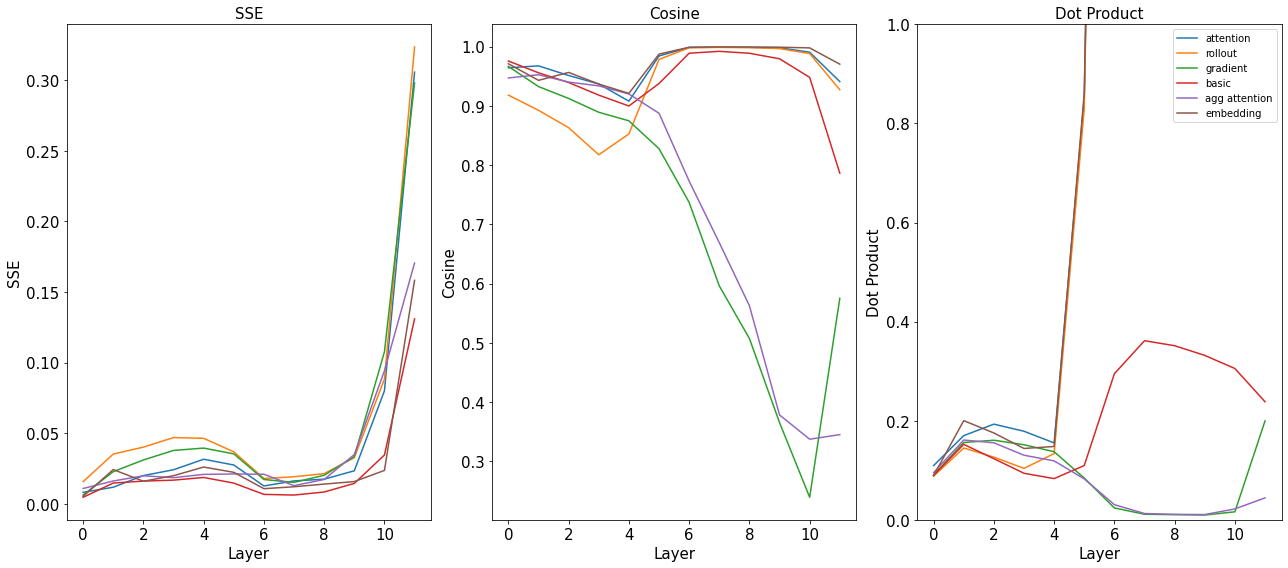

In [41]:
# using scales
plot_all_distances_per_metrics(0,1,True,scales,sse_list_attention, sse_list_rollout, sse_list_gradient, sse_list_basic, sse_list_agg_attention, sse_list_embedding,
                                  cosine_list_attention, cosine_list_rollout, cosine_list_gradient, cosine_list_basic, cosine_list_agg_attention, cosine_list_embedding,
                                  dot_list_attention, dot_list_rollout, dot_list_gradient, dot_list_basic, dot_list_agg_attention, dot_list_embedding)

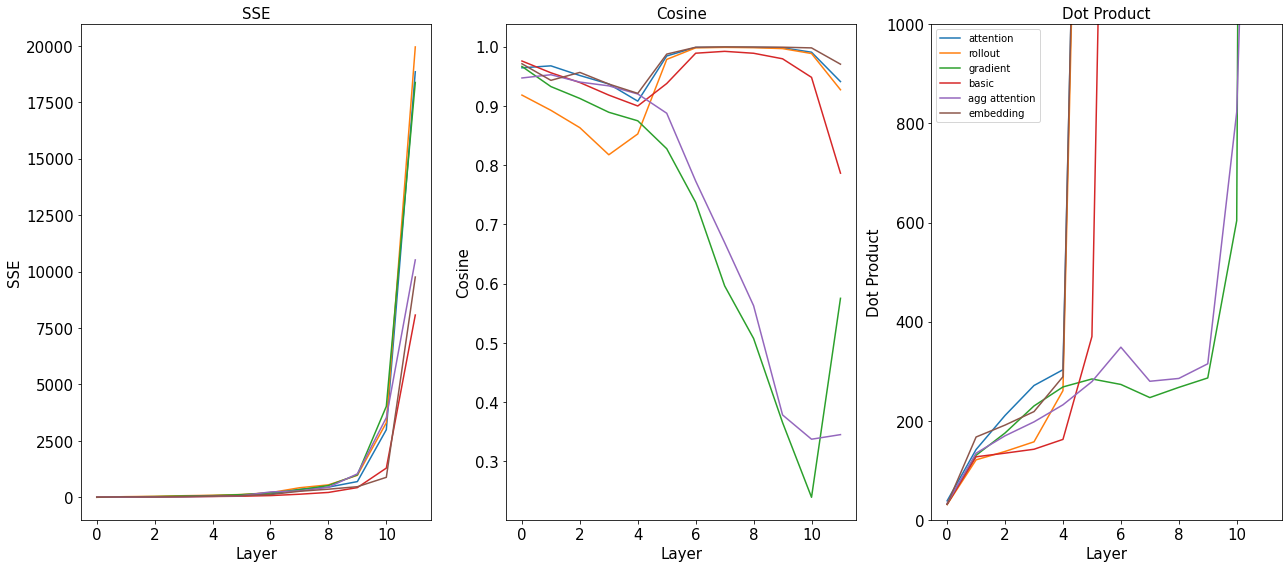

In [42]:
# without scales
plot_all_distances_per_metrics(0,1,False,scales,sse_list_attention, sse_list_rollout, sse_list_gradient, sse_list_basic, sse_list_agg_attention, sse_list_embedding,
                                  cosine_list_attention, cosine_list_rollout, cosine_list_gradient, cosine_list_basic, cosine_list_agg_attention, cosine_list_embedding,
                                  dot_list_attention, dot_list_rollout, dot_list_gradient, dot_list_basic, dot_list_agg_attention, dot_list_embedding)

In [43]:
#plot_all_distances_per_layer(sse_list_attention, cosine_list_attention, dot_list_attention, "attention")
#plot_all_distances_per_layer(sse_list_rollout, cosine_list_rollout, dot_list_rollout, "rollout")
#plot_all_distances_per_layer(sse_list_gradient, cosine_list_gradient, dot_list_gradient, "gradient")
#plot_all_distances_per_layer(sse_list_basic, cosine_list_basic, dot_list_basic, "basic")
#plot_all_distances_per_layer(sse_list_agg_attention, cosine_list_agg_attention, dot_list_agg_attention, "aggregated attention")
#plot_all_distances_per_layer(sse_list_embedding, cosine_list_embedding, dot_list_embedding, "embedding relevance")

## Sanity Check

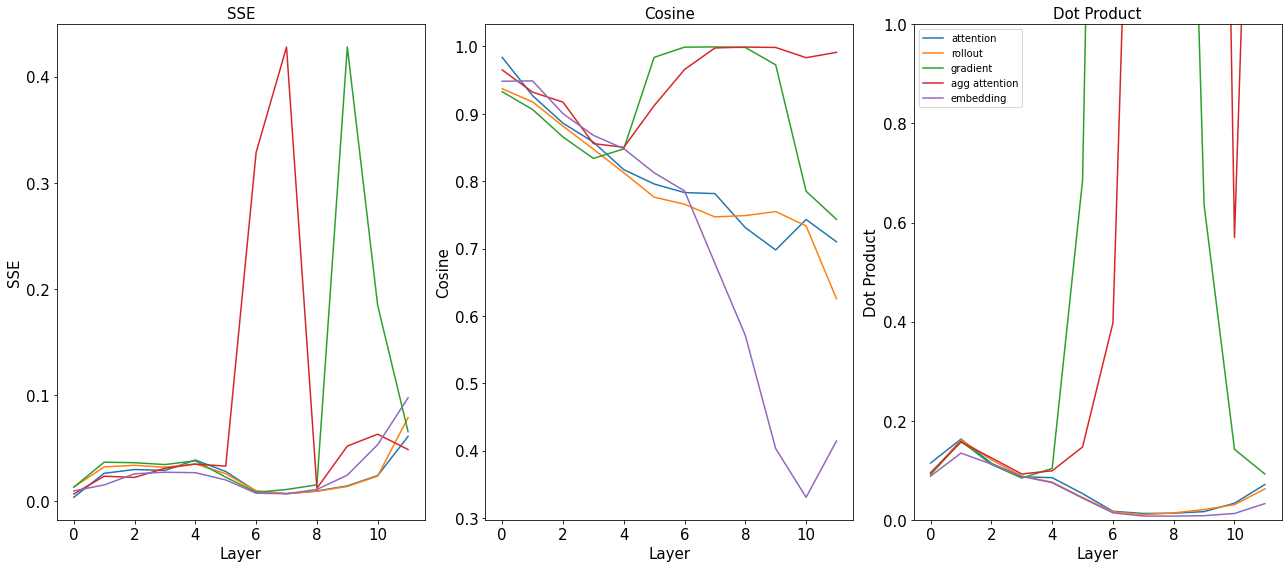

In [44]:
plot_all_distances_per_metrics(0,1,True,scales,sse_list_attention_flipped, sse_list_rollout_flipped, sse_list_gradient_flipped, None, sse_list_agg_attention_flipped, sse_list_embedding_flipped,
                                  cosine_list_attention_flipped, cosine_list_rollout_flipped, cosine_list_gradient_flipped, None, cosine_list_agg_attention_flipped, cosine_list_embedding_flipped,
                                  dot_list_attention_flipped, dot_list_rollout_flipped, dot_list_gradient_flipped, None, dot_list_agg_attention_flipped, dot_list_embedding_flipped)

In [45]:
#plot_all_distances_per_layer(sse_list_attention_flipped, cosine_list_attention_flipped, dot_list_attention_flipped, "attention flipped")
#plot_all_distances_per_layer(sse_list_rollout_flipped, cosine_list_rollout_flipped, dot_list_rollout_flipped, "rollout flipped")
#plot_all_distances_per_layer(sse_list_gradient_flipped, cosine_list_gradient_flipped, dot_list_gradient_flipped, "gradient flipped")
#plot_all_distances_per_layer(sse_list_agg_attention_flipped, cosine_list_agg_attention_flipped, dot_list_agg_attention_flipped, "aggregated attention flipped")
#plot_all_distances_per_layer(sse_list_embedding_flipped, cosine_list_embedding_flipped, dot_list_embedding_flipped, "embedding relevance flipped")

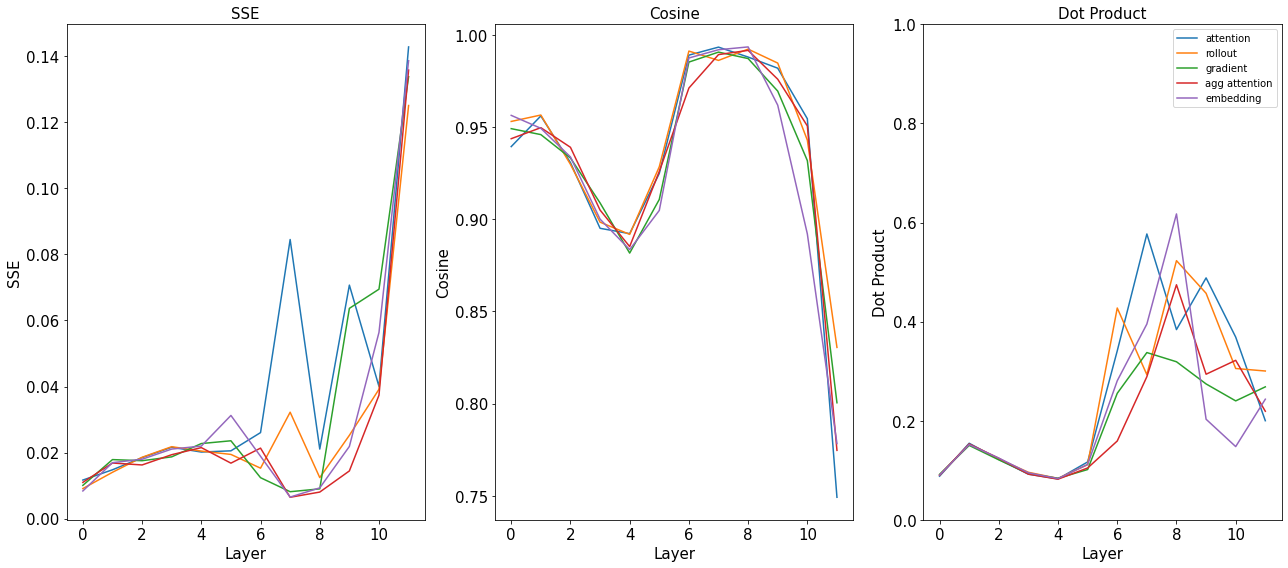

In [46]:
plot_all_distances_per_metrics(0,1,True,scales,sse_list_attention_random, sse_list_rollout_random, sse_list_gradient_random, None, sse_list_agg_attention_random, sse_list_embedding_random,
                                  cosine_list_attention_random, cosine_list_rollout_random, cosine_list_gradient_random, None, cosine_list_agg_attention_random, cosine_list_embedding_random,
                                  dot_list_attention_random, dot_list_rollout_random, dot_list_gradient_random, None, dot_list_agg_attention_random, dot_list_embedding_random)

In [47]:
#plot_all_distances_per_layer(sse_list_attention_random, cosine_list_attention_random, dot_list_attention_random, "attention random")
#plot_all_distances_per_layer(sse_list_rollout_random, cosine_list_rollout_random, dot_list_rollout_random, "rollout random")
#plot_all_distances_per_layer(sse_list_gradient_random, cosine_list_gradient_random, dot_list_gradient_random, "gradient random")
#plot_all_distances_per_layer(sse_list_agg_attention_random, cosine_list_agg_attention_random, dot_list_agg_attention_random, "aggregated attention random")
#plot_all_distances_per_layer(sse_list_embedding_random, cosine_list_embedding_random, dot_list_embedding_random, "embedding relevance random")

# Within concept distance/similarity

In [48]:
image_ind1 = 0
image_ind2 = 1
concept_num1=0
concept_num2=0

sse_list = []
cosine_list = []
dot_list = []
sse_list_topk = []
cosine_list_topk = []
dot_list_topk = []



for layer_num in range(12):
    relevances_attention = get_attention_relevance(attentions_list[concept_num1], layer_num)
    
    image_embedding1 = image_embedding(embeddings_list[concept_num1][layer_num][image_ind1])
    image_embedding2 = image_embedding(embeddings_list[concept_num1][layer_num][image_ind2])
    image_embedding1_topk = image_embedding_top_k(embeddings_list[concept_num1][layer_num][image_ind1], k, relevances_attention[image_ind1], "top")
    image_embedding2_topk = image_embedding_top_k(embeddings_list[concept_num1][layer_num][image_ind2], k, relevances_attention[image_ind2], "top")
    
    sse_list.append(embedding_distance(image_embedding1, image_embedding2, "sse"))
    cosine_list.append(embedding_distance(image_embedding1, image_embedding2, "cosine"))
    dot_list.append(embedding_distance(image_embedding1, image_embedding2, "dot_product"))
    
    sse_list_topk.append(embedding_distance(image_embedding1_topk, image_embedding2_topk, "sse"))
    cosine_list_topk.append(embedding_distance(image_embedding1_topk, image_embedding2_topk, "cosine"))
    dot_list_topk.append(embedding_distance(image_embedding1_topk, image_embedding2_topk, "dot_product"))

In [49]:
#plot_all_distances_per_layer(sse_list, cosine_list, dot_list, "distance image0&image1: no topk")
#plot_all_distances_per_layer(sse_list_topk, cosine_list_topk, dot_list_topk, "distance image0&image1: topk")

# Looking at Concept CLS Token

In [50]:
# average the embedding of the class token for a concept -> concept cls embedding
def avg_cls(embedding):
    embedding = embedding.numpy() # (20, 197, 768)
    cls = embedding[:,0,:] # only take cls tokens (20, 768)
    cls = np.mean(cls, axis=0) # avg over batch (768)
    return cls

In [51]:
# trying this for the two chosen concepts above
sse_list_cls = []
cosine_list_cls = []
dot_list_cls = []

concept_num1 = 0
concept_num2 = 1

# get avg cls embeddings at each layer
for layer_num in range(12):
    cls1 = avg_cls(embeddings_list[concept_num1][layer_num])
    cls2 = avg_cls(embeddings_list[concept_num2][layer_num])
    
    sse_list_cls.append(embedding_distance(cls1, cls2, "sse"))
    cosine_list_cls.append(embedding_distance(cls1, cls2, "cosine"))
    dot_list_cls.append(embedding_distance(cls1, cls2, "dot_product")) 

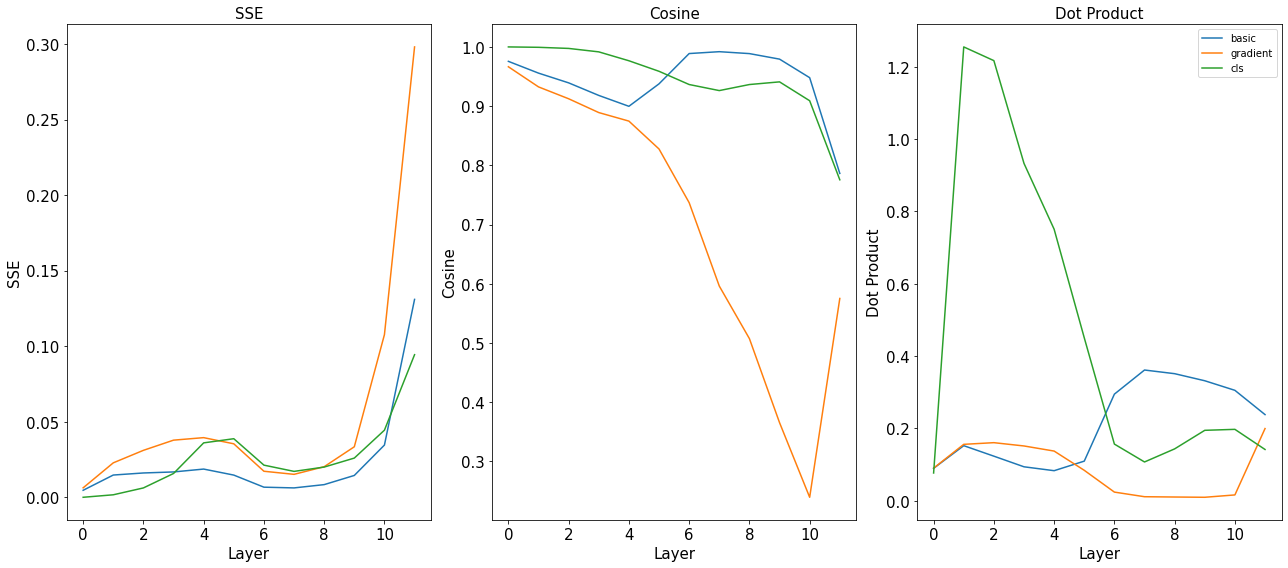

In [52]:
fig, ax = plt.subplots(1,3)
fig.set_figheight(8)
fig.set_figwidth(18)

ax[0].plot(range(12),sse_list_basic/(scales**2), label="basic")
ax[0].plot(range(12),sse_list_gradient/(scales**2), label="gradient")
ax[0].plot(range(12),sse_list_cls/(scales**2), label="cls")
ax[0].set_xlabel("Layer", fontsize=15)
ax[0].set_ylabel("SSE", fontsize=15)
ax[0].set_title("SSE", fontsize=15)
ax[0].tick_params(labelsize=15)

ax[1].plot(range(12),cosine_list_basic, label="basic")
ax[1].plot(range(12),cosine_list_gradient, label="gradient")
ax[1].plot(range(12),cosine_list_cls, label="cls")
ax[1].set_xlabel("Layer", fontsize=15)
ax[1].set_ylabel("Cosine", fontsize=15)
ax[1].set_title("Cosine", fontsize=15)
ax[1].tick_params(labelsize=15)

ax[2].plot(range(12),dot_list_basic/(scales**2), label="basic")
ax[2].plot(range(12),dot_list_gradient/(scales**2), label="gradient")
ax[2].plot(range(12),dot_list_cls/(scales**2), label="cls")
ax[2].set_xlabel("Layer", fontsize=15)
ax[2].set_ylabel("Dot Product", fontsize=15)
ax[2].set_title("Dot Product", fontsize=15)
ax[2].tick_params(labelsize=15)

    
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
#plot_all_distances_per_layer(sse_list, cosine_list, dot_list, "Avg CLS")

### Visualize Norm of Concept Embedding with respect to Layer Number for different Concepts and k values

In [54]:
def calculate_concept_embeddings(concept_num, k):
    # Initialize lists to store concept embeddings for different relevance types
    concept_embeddings = {
        'basic': [],
        'attention': [],
        'rollout': [],
        'gradient': [],
        'agg_attention': [],
        'embedding': []
    }

    # Iterate over each layer
    for layer_num in range(12):
        # Compute relevances for the current concept
        relevances_attention = get_attention_relevance(attentions_list[concept_num], layer_num)
        relevances_rollout = get_rollout_relevance(concepts_selected[concept_num], model, layer_num)
        relevances_gradient = get_gradient_relevance(concepts_selected[concept_num], layer_num)
        relevances_agg_attention = get_agg_attention_relevance(attentions_list[concept_num], layer_num, aggregation_type='max')
        relevances_embedding = get_embedding_relevance(embeddings_list[concept_num], layer_num)

        # Store average concept embeddings for each relevance type
        concept_embeddings['basic'].append(average_embedding(embeddings_list[concept_num][layer_num]))
        concept_embeddings['attention'].append(average_embedding_top_k(embeddings_list[concept_num][layer_num], k, relevances_attention, "top"))
        concept_embeddings['rollout'].append(average_embedding_top_k(embeddings_list[concept_num][layer_num], k, relevances_rollout, "top"))
        concept_embeddings['gradient'].append(average_embedding_top_k(embeddings_list[concept_num][layer_num], k, relevances_gradient, "top"))
        concept_embeddings['agg_attention'].append(average_embedding_top_k(embeddings_list[concept_num][layer_num], k, relevances_agg_attention, "top"))
        concept_embeddings['embedding'].append(average_embedding_top_k(embeddings_list[concept_num][layer_num], k, relevances_embedding, "top"))

    return concept_embeddings

In [55]:
def calculate_norms(concept_embeddings):
    # Calculate the norm of each concept embedding for all layers
    norms = {
        'basic': [np.linalg.norm(embedding) for embedding in concept_embeddings['basic']],
        'attention': [np.linalg.norm(embedding) for embedding in concept_embeddings['attention']],
        'rollout': [np.linalg.norm(embedding) for embedding in concept_embeddings['rollout']],
        'gradient': [np.linalg.norm(embedding) for embedding in concept_embeddings['gradient']],
        'agg_attention': [np.linalg.norm(embedding) for embedding in concept_embeddings['agg_attention']],
        'embedding': [np.linalg.norm(embedding) for embedding in concept_embeddings['embedding']]
    }

    return norms

In [58]:
def plot_norms(norms, concept_num, k):
    # Plot the norms of concept embeddings vs layer number
    layers = range(1, 13)

    plt.figure(figsize=(10, 6))
    plt.plot(layers, norms['basic'], label='basic')
    plt.plot(layers, norms['attention'], label='attention')
    plt.plot(layers, norms['rollout'], label='rollout')
    plt.plot(layers, norms['gradient'], label='gradient')
    plt.plot(layers, norms['agg_attention'], label='agg attention')
    plt.plot(layers, norms['embedding'], label='embedding')

    plt.xlabel('Layer', fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylabel(f'Norm', fontsize=15)
    plt.yticks(fontsize=15)
    #plt.title(f'Norm of Concept Embedding vs Layer Number for Concept {concept_num}, k={k}', fontsize=20)
    plt.title(f'Norm of Concept Embedding', fontsize=15)
    plt.legend()
    plt.show()

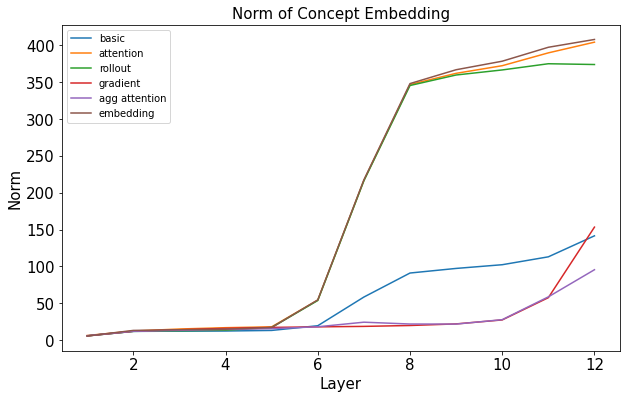

In [59]:
#k_list = [32, 64, 128]
k_list = [50]

for concept_num in range(0, 1):  # len(concepts)):
    for k in k_list:
        concept_embeddings = calculate_concept_embeddings(concept_num, k)
        norms = calculate_norms(concept_embeddings)
        plot_norms(norms, concept_num, k)